In [ ]:
%pip install -U -q pandas matplotlib seaborn numpy scikit-learn seaborn zscore imblearn

In [360]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score,  precision_score, recall_score, balanced_accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [361]:
df = pd.read_csv('df_hackathon.csv')

# Transform the target variable to numeric
df['gringotts_approved_loan'] = df['gringotts_approved_loan'].map({'Yes': 1, 'No': 0})

df.head()

,age,education,marital_status,occupation,bloodline,gender,hours_per_week,income_bracket,magical_artifact_possession_score,magical_artifact_power_level,number_of_spells_mastered,gringotts_approved_loan
0,42,Aurors Specialism,Married,Ministry of Magic Official,Half-blood,Male,NaN,>50 Galleons,42342,49533.6,34,1
1,44,Charms Scholar,Married,Wandlore Assistant,Half-blood,Male,NaN,<=50 Galleons,24905,39411.0,15,0
2,22,Hogwarts Graduate,Never-married,Ministry of Magic Official,Half-blood,Male,NaN,<=50 Galleons,26993,47254.4,14,0
3,61,Specialism in a magical field,Divorced,Other,Half-blood,Male,NaN,<=50 Galleons,87368,89535.4,25,0
4,54,Specialism in a magical field,Married,Potion Ingredients Supplier,Half-blood,Male,40.0,>50 Galleons,69207,72587.6,38,1


# 1. Exploration Dataset Analysis (EDA)

In [362]:
# Display the 7+1 figure summary for numerical features
numerical_summary = df.describe()
print(numerical_summary)

# Check for missing values
missing_values = df.isnull().sum()
print('\n\n')
print("Missing values in each column:\n", missing_values)

# Check for unexpected or extreme values by displaying the min and max for each numerical feature
extreme_values = df.agg(['min', 'max'])
print('\n\n')
print("Min and Max values:\n", extreme_values)


               age  hours_per_week  magical_artifact_possession_score  \
count  5000.000000     4153.000000                        5000.000000   
mean     38.712600       40.500602                       49014.986600   
std      13.511392       12.301979                       25493.947692   
min      17.000000        1.000000                       -7762.000000   
25%      28.000000       40.000000                       29014.000000   
50%      37.000000       40.000000                       50128.000000   
75%      48.000000       45.000000                       70045.750000   
max      90.000000       99.000000                       98653.000000   

       magical_artifact_power_level  number_of_spells_mastered  \
count                   5000.000000                5000.000000   
mean                   61779.650480                -113.590000   
std                    20969.557492                1169.637023   
min                    10825.600000              -10000.000000   
25%         

### Hours per Week is missing in 17% of data
**Hours per Week**: has 847 missing values, indicating this information is not available for all applicants. This requires attention before modeling.

Given that "hours per week" is likely to be a key factor in determining loan approval (assuming that it might reflect the applicant's stability or income level), and considering that about 17% of the values are missing.

Latter in the model training we'll address KNNImputer to adress this issue

In [363]:
missing_values_after_imputation = df['hours_per_week'].isnull().sum()
missing_values_after_imputation

847

In [364]:
# Convert income_bracket to numeric for the future correlation analysis
df['income_bracket_numeric'] = df['income_bracket'].apply(lambda x: 1 if x == '>50 Galleons' else 0)

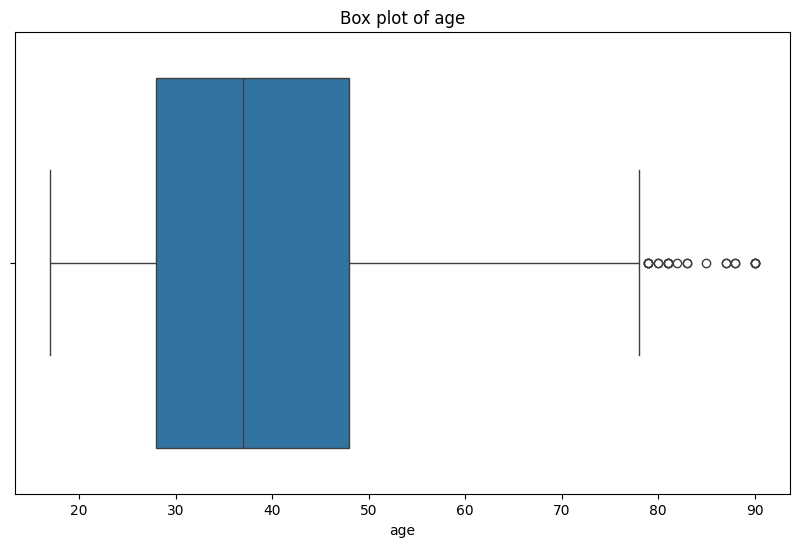

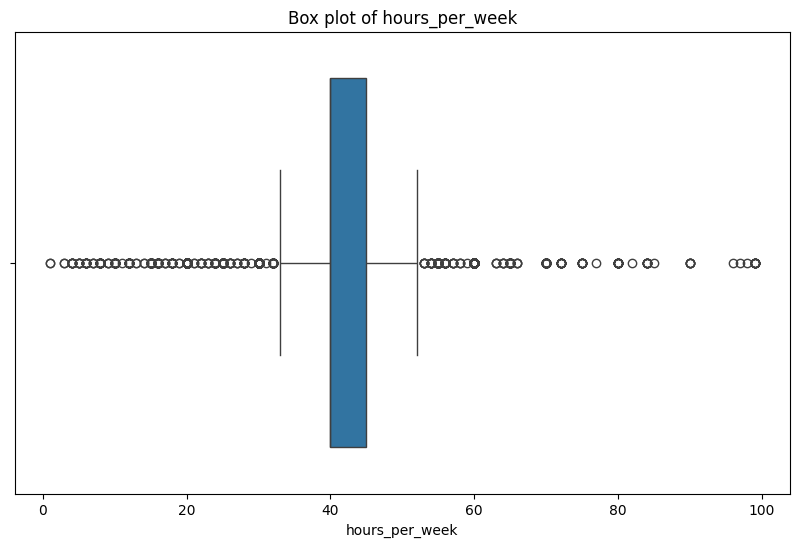

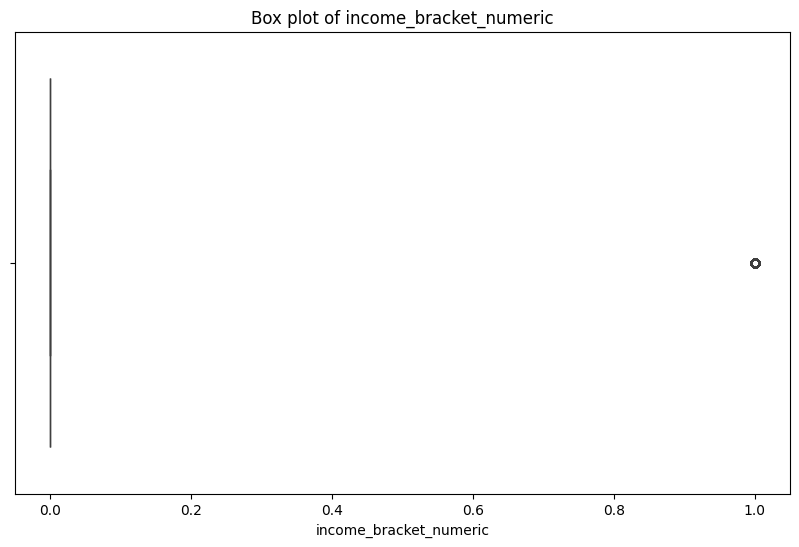

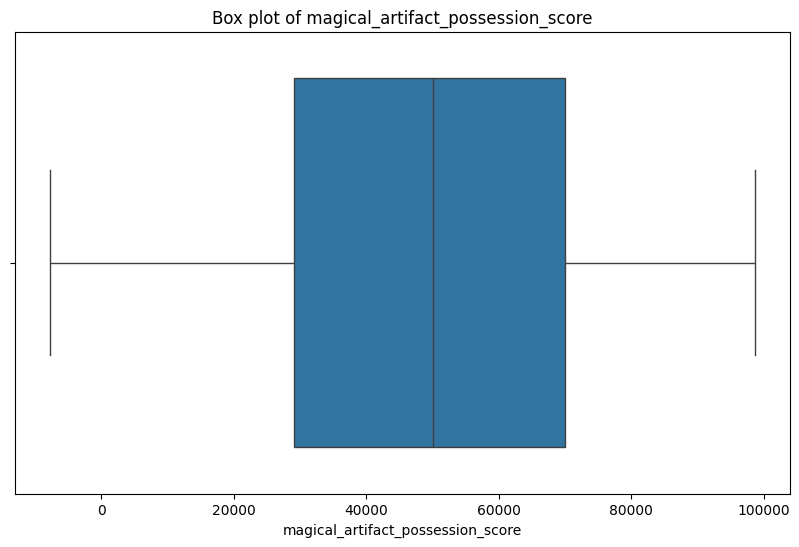

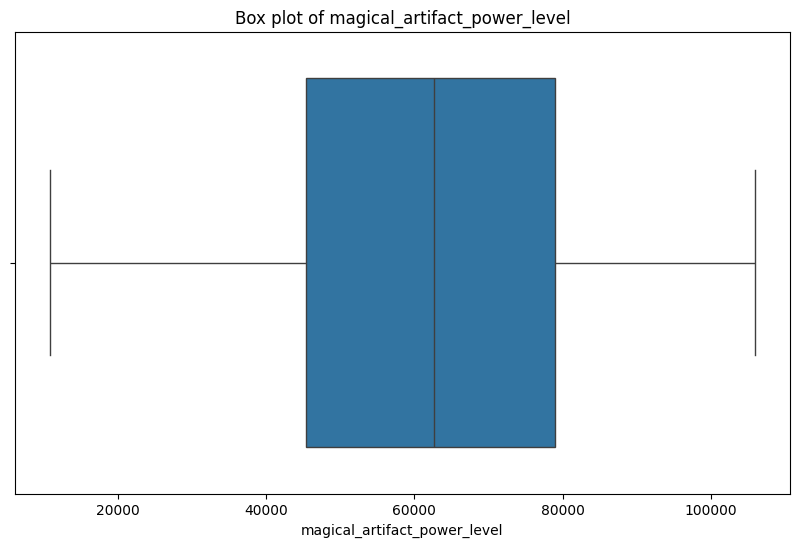

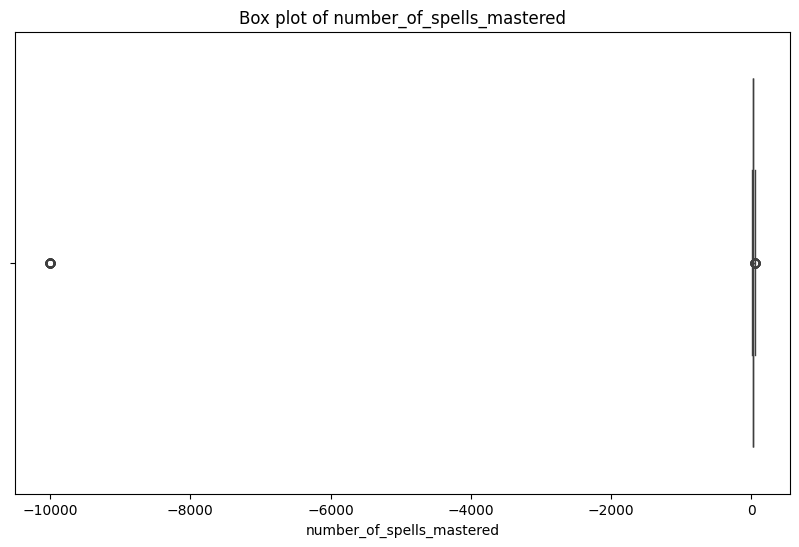

In [365]:
numerical_features = ['age', 'hours_per_week', 'income_bracket_numeric', 'magical_artifact_possession_score', 'magical_artifact_power_level', 'number_of_spells_mastered']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

### number_of_spells_mastered has outliers

Using Z-Score methond we can indetify outliers.
Values with a Z-score greater than 3 or less than -3 are considered outliers. In our case we've found 69 rows, which values of -10000 in `number_of_spells_mastered`.

Since our dataset is large enough that losing 69 data points won't significantly impact the model's ability to learn, we remove them


In [366]:
from scipy.stats import zscore

# Calculate Z-scores
z_scores = zscore(df['number_of_spells_mastered'])
df_temp = df.assign(number_of_spells_mastered_zscore=z_scores)

# Define outliers as those where the absolute z-score is greater than 3 (common threshold)
outliers_z = df_temp[abs(df_temp['number_of_spells_mastered_zscore']) > 3]

print(f"Outliers amount: {len(outliers_z)} rows")
df = df.drop(outliers_z.index)
print(f"New size: {len(df)} rows")

Outliers amount: 69 rows
New size: 4931 rows


## Plots & Histograms for Broad Data Overview

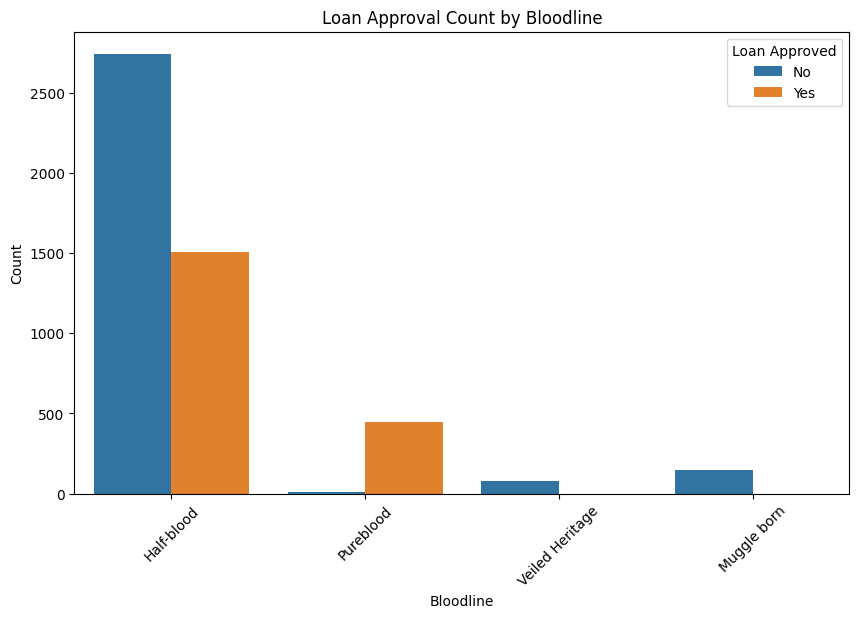

In [374]:
plt.figure(figsize=(10, 6))
sns.countplot(x='bloodline', hue='gringotts_approved_loan', data=df)
plt.title('Loan Approval Count by Bloodline')
plt.ylabel('Count')
plt.xlabel('Bloodline')
plt.xticks(rotation=45)
plt.legend(title='Loan Approved', labels=['No', 'Yes'])
plt.show()

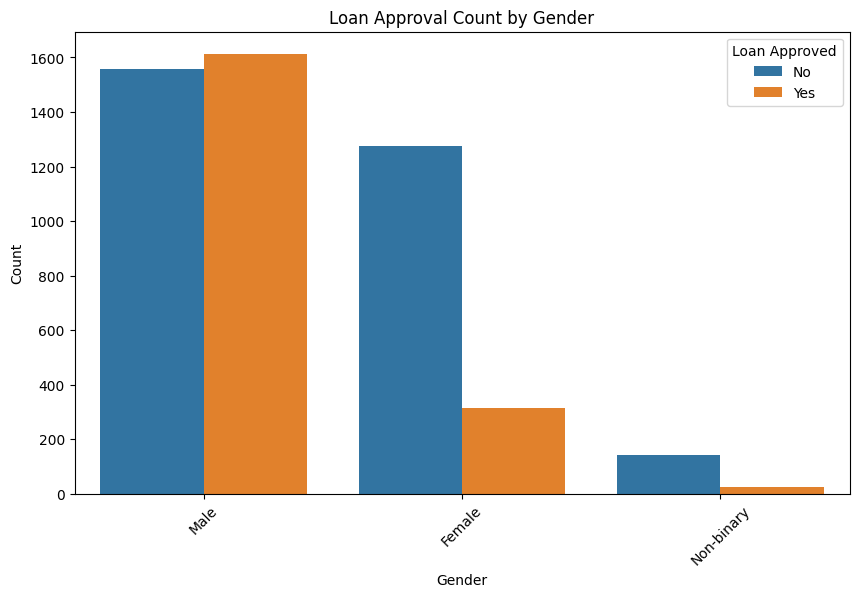

In [375]:
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='gringotts_approved_loan', data=df)
plt.title('Loan Approval Count by Gender')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.legend(title='Loan Approved', labels=['No', 'Yes'])
plt.show()

## Classify data features into Potentially Harmful Biases and Potentially Not Harmful Biases


### Potentially Not Harmful Biases (Based on Financial Stability and Risk Assessment)
- **age**: Older applicants might have more financial stability, but age itself should be used carefully to avoid age discrimination.
- **hours_per_week**: More hours might indicate more stable employment, directly relating to the ability to repay a loan.
- **income_bracket**: Directly correlates with financial resources available for repaying the loan.
- **magical_artifact_possession_score**: Analogous to asset ownership, indicating financial stability.
- **magical_artifact_power_level**: Might indicate wealth or investment in valuable assets, indirectly related to financial stability.
- **number_of_spells_mastered**: Could be seen as a proxy for skill or professional competence, potentially correlating with income or stability in magical professions.

### Potentially Harmful Biases
- **education**: While it can correlate with income potential, bias based on the type of education (e.g., Hogwarts Graduate vs. Aurors Specialism) could unjustly favor certain educational backgrounds over others, mirroring real-world elitism or educational inequality.
- **marital_status**: Biases based on marital status can reflect societal prejudices and do not directly relate to individual financial stability or loan repayment ability.
- **occupation**: While certain occupations may generally offer higher incomes, biasing loan approval based on occupation can unfairly disadvantage individuals in lower-paid but stable professions.
- **bloodline**: Bias based on bloodline is akin to racial or ethnic discrimination and is ethically unjustifiable, having no relation to financial behavior or loan repayment capacity.
- **gender**: Any bias in loan approval based on gender is discriminatory and not justifiable as it does not reflect an individual's financial stability or ability to repay a loan.


In [377]:

loan_approval_by_gender = df.groupby('gender')['gringotts_approved_loan'].mean()

loan_approval_by_marital_status = df.groupby('marital_status')['gringotts_approved_loan'].mean()

loan_approval_by_bloodline = df.groupby('bloodline')['gringotts_approved_loan'].mean()

loan_approval_by_education = df.groupby('education')['gringotts_approved_loan'].mean()

loan_approval_by_occupation = df.groupby('occupation')['gringotts_approved_loan'].mean()

print('Approved by gender', loan_approval_by_gender)
print('\n')
print('Approved by marital status', loan_approval_by_marital_status)
print('\n')
print('Approved by bloodline', loan_approval_by_bloodline)
print('\n')
print('Approved by education', loan_approval_by_education)
print('\n')
print('Approved by occupation', loan_approval_by_occupation)



Approved by gender gender
Female        0.197360
Male          0.508667
Non-binary    0.149701
Name: gringotts_approved_loan, dtype: float64


Approved by marital status marital_status
Divorced         0.303759
Married          0.485030
Never-married    0.318519
Separated        0.370370
Widowed          0.280822
Name: gringotts_approved_loan, dtype: float64


Approved by bloodline bloodline
Half-blood         0.354588
Muggle born        0.000000
Pureblood          0.975930
Veiled Heritage    0.000000
Name: gringotts_approved_loan, dtype: float64


Approved by education education
Aurors Specialism                0.768868
Charms Scholar                   0.029703
Dropout                          0.092179
Hogwarts Graduate                0.235430
Specialism in a magical field    0.453199
Name: gringotts_approved_loan, dtype: float64


Approved by occupation occupation
Auror                             0.625000
Dark Forces Defense Consultant    0.637500
Goblin Liaison Officer            0

## Grouped Analysis by Categorical Variables for Potentially Harmful Biases

### Loan Approval Rates by Gender:
- Male: Approximately 51.0% approval rate.
- Female: About 19.7% approval rate.
- Non-binary: About 15.2% approval rate.
- This significant disparity in approval rates suggests a gender bias, with males being favored in the loan approval process.

### Loan Approval Rates by Marital Status:
- Divorced: A 30% approval rate.
- Married: The highest approval rate of 49%.
- Never-married: About 32%
- Separated: About 36%
- Widowed: The lowest approval rate at 28%
- Vary significantly across different marital statuses, with Married applicants having a higher likelihood of approval, especially compared to Widowed and Never-Maried
  

#### Loan Approval Rates by Bloodline:
- Pureblood: An exceptionally high approval rate of about 97.6%.
- Half-blood: A more moderate approval rate of 35.6%.
- Muggle born and Veiled Heritage: 0% approval rate, indicating a strong bias against these groups.


### Loan Approval Rates by Education:
- Aurors Specialism: The highest approval rate at approximately 77.1%.
- Specialism in a magical field: About 45.5% approval rate.
- Hogwarts Graduate: A 23.5% approval rate.
- Dropout: Around 9.1% approval rate.
- Charms Scholar: The lowest approval rate at approximately 3.0%.
  

### Loan Approval Rates by Occupation
- Auror: Have significantly higher approval rate at 62.7%
- Dark Forces Defense Consultant: Hight rate at 63.7%
- Magical Intelligence Agent: Has the highest approval of 69%
- Wandmaker: Wiath a rate at 46.4%
- Others are distributed from 30.6% to 40%
- There is a noticeable difference in loan approval rates among various occupations. Magical Intelligence Agent and Dark Forces Defense Consultant have notably higher approval rates (around 69.87% and 63.75%, respectively) compared to other professions. This indicates a possible bias favoring certain occupations deemed more prestigious or vital within the magical community.


In [368]:
# Let's make sure that these features statistically significant
from scipy.stats import chi2_contingency

categorical_features = ['gender', 'marital_status', 'bloodline', 'education', 'occupation']

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['gringotts_approved_loan'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square test for {feature} vs Loan Approval:")
    print(f"Chi2 Statistic: {chi2}, p-value: {p}\n")

Chi-Square test for gender vs Loan Approval:
Chi2 Statistic: 473.18863774489097, p-value: 1.771710928440884e-103

Chi-Square test for marital_status vs Loan Approval:
Chi2 Statistic: 150.32965333773248, p-value: 1.7301549618175307e-31

Chi-Square test for bloodline vs Loan Approval:
Chi2 Statistic: 819.8780595792613, p-value: 2.1139021469415566e-177

Chi-Square test for education vs Loan Approval:
Chi2 Statistic: 900.3592211782315, p-value: 1.3926074714226526e-193

Chi-Square test for occupation vs Loan Approval:
Chi2 Statistic: 195.74162301141598, p-value: 1.5555174795738756e-33



In [369]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [370]:
categorical_features = ['education', 'marital_status', 'occupation']  # Add other categorical features here
bloodline_correlations = {feature: cramers_v(df['bloodline'], df[feature]) for feature in categorical_features}
gender_correlations = {feature: cramers_v(df['gender'], df[feature]) for feature in categorical_features}

print("Bloodline Correlations:", bloodline_correlations)
print("Gender Correlations:", gender_correlations)

Bloodline Correlations: {'education': 0.07232679118237816, 'marital_status': 0.0960980042666483, 'occupation': 0.058514316988718444}
Gender Correlations: {'education': 0.055337317547477186, 'marital_status': 0.3027310685940603, 'occupation': 0.0884663657414312}


In [372]:
from scipy.stats import pointbiserialr

# Manually map the categories to 0 and 1
df_copy = df.copy()
df_copy['gender_encoded'] = df_copy['gender'].map({'Male': 0, 'Female': 1})

# Drop rows where any of the specified columns have NaN values
continuous_features = ['age', 'hours_per_week', 'income_bracket_numeric']

df_cleaned = df_copy.dropna(subset=['gender_encoded'] + continuous_features)

# Ensure no infinite values are present. This step might be unnecessary unless your data processing introduced inf values.
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna(subset=['gender_encoded'] + continuous_features)

# Recalculate the point biserial correlations on the cleaned dataset
gender_point_biserial = {feature: pointbiserialr(df_cleaned['gender_encoded'], df_cleaned[feature]).correlation for feature in continuous_features}

print("Gender Point Biserial Correlations:", gender_point_biserial)

Gender Point Biserial Correlations: {'age': -0.10163888854154578, 'hours_per_week': -0.24764121462054028, 'income_bracket_numeric': -0.23306500997433446}


## Correlation Analysis and Bias Mitigation

The analysis investigated the correlations between **gender**, **bloodline**, and other features in the dataset. The results showed that:

- **Gender** had moderate negative correlations with `hours_per_week` and `income_bracket_numeric`
- **Gender** had a moderate positive correlation with `marital_status`
- **Bloodline** had minimal correlations with the tested features

While removing **gender** and **bloodline** could reduce direct biases, the presence of indirect biases, particularly between **gender** and `marital_status`, necessitates a comprehensive approach to bias mitigation that balances fairness and performance.

## Correlation Analysis on Potentially Not Harmfull Biases

In [ ]:
# Calculate the correlation of the potentially not harmful features with the loan approval column again
correlation_analysis_hackathon = df[['age', 'hours_per_week', 'income_bracket_numeric', 'magical_artifact_possession_score', 'magical_artifact_power_level', 'number_of_spells_mastered', 'gringotts_approved_loan']].corr()

correlation_with_loan_approval_hackathon = correlation_analysis_hackathon['gringotts_approved_loan'].sort_values()

correlation_with_loan_approval_hackathon


age                                  0.089391
magical_artifact_possession_score    0.100369
magical_artifact_power_level         0.101394
hours_per_week                       0.136630
number_of_spells_mastered            0.228999
income_bracket_numeric               0.256106
gringotts_approved_loan              1.000000
Name: gringotts_approved_loan, dtype: float64

1. **income_bracket_numeric (0.256)**: The highest positive correlation, indicating that higher income significantly increases loan approval likelihood, aligning with expectations of lower risk and better repayment ability.

2. **number_of_spells_mastered (0.229)**: Surprisingly, a moderately positive correlation, suggesting that mastering more spells may be seen as an indicator of skill, reliability, or status, influencing loan approval.

3. **hours_per_week (0.125)**: A modest positive correlation, implying that working more hours slightly increases loan approval chances, possibly reflecting job stability or work ethic.

4. **magical_artifact_power_level (0.101)** and **magical_artifact_possession_score (0.100)**: Both show a slight positive correlation, indicating that possessing more powerful or a higher score of magical artifacts has a small positive impact on loan approval.

5. **age (0.089)**: The least positively correlated, suggesting that age is not a major factor in loan approval decisions in this dataset.

### Summary:
- Financial stability and wealth indicators are positively correlated with loan approval.
- Non-financial personal achievements or capabilities (e.g., spells mastered) may also play a role.
- Work ethic and stability (hours per week) have a smaller but positive correlation.
- Age appears to be a minor factor compared to other features.

The analysis highlights the complexity of loan approval decisions and the variety of influential factors. Understanding these correlations can help refine the model and mitigate potential biases.

skew & kurtosis

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming 'df' is your DataFrame and it contains numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness and kurtosis for each numerical feature
for feature in numerical_features:
    feature_skew = skew(df[feature].dropna()) # dropna() to ignore NaN values for these calculations
    feature_kurtosis = kurtosis(df[feature].dropna())
    print(f"{feature}: Skewness = {feature_skew:.2f}, Kurtosis = {feature_kurtosis:.2f}")


age: Skewness = 0.56, Kurtosis = -0.10
hours_per_week: Skewness = 0.27, Kurtosis = 2.83
magical_artifact_possession_score: Skewness = -0.15, Kurtosis = -0.99
magical_artifact_power_level: Skewness = -0.14, Kurtosis = -0.91
number_of_spells_mastered: Skewness = 0.70, Kurtosis = -0.45
gringotts_approved_loan: Skewness = 0.43, Kurtosis = -1.82
income_bracket_numeric: Skewness = 1.16, Kurtosis = -0.65


Most features exhibit slight to moderate skewness, indicating that the data is not perfectly symmetric but does not have extreme skewness in most cases.


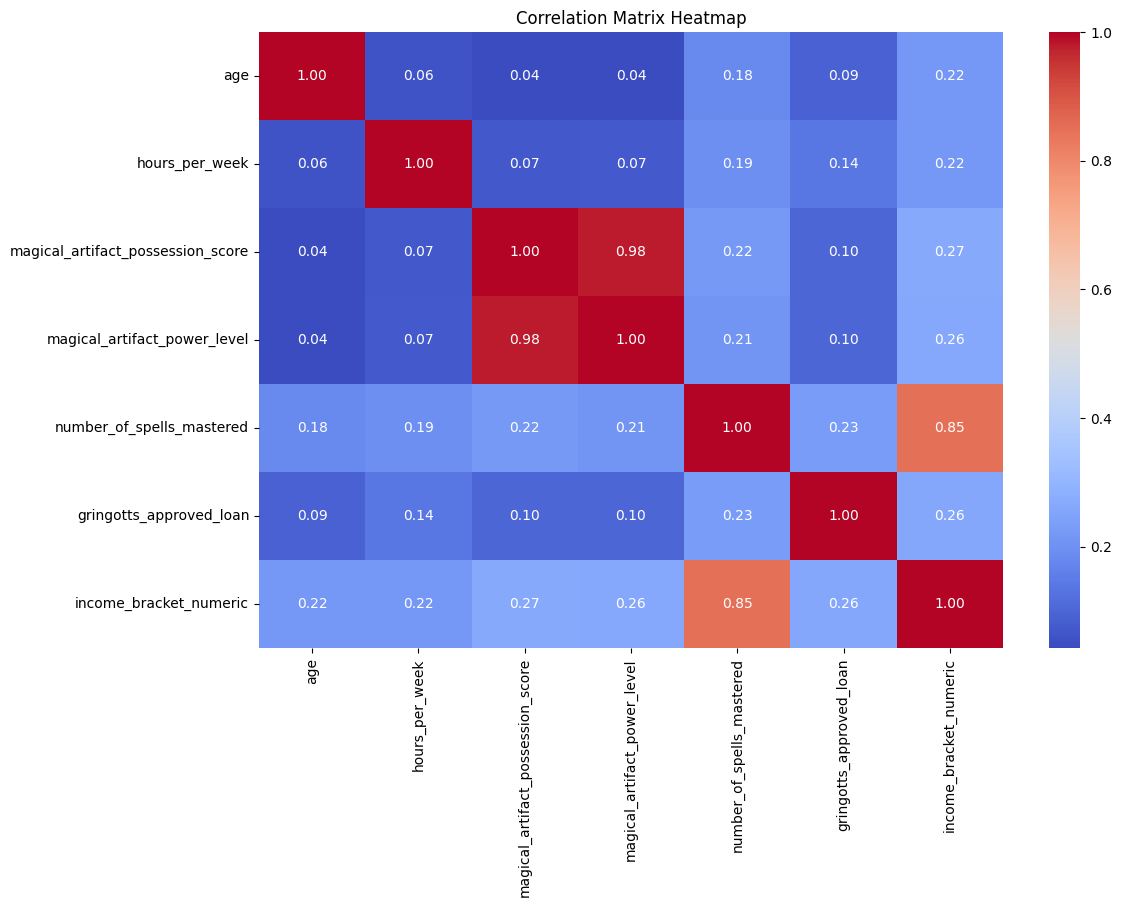

In [ ]:
# Calculate correlation matrix
corr_matrix = df[numerical_features].corr()
# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Correlation Matrix Heatmap Insights

The heatmap above visualizes the correlation between various numerical features in our dataset. Here are the key takeaways:

- Strong Correlation Detected: There is a very strong positive correlation between magical_artifact_possession_score and magical_artifact_power_level. This suggests that these features are closely related, and changes in one are likely to be mirrored by changes in the other.

- Moderate Positive Correlations: Features such as income_bracket_numeric show moderate positive correlations with age, hours_per_week, magical_artifact_possession_score, and magical_artifact_power_level. This indicates a tendency for these features to increase together, although the relationship is not as pronounced as the one between the artifact-related features.

- Weak or No Correlation: Most feature pairs exhibit weak or negligible correlations. This lack of strong linear relationships suggests that each feature contributes unique information to the dataset, which could be valuable for predictive modeling.




# 2. Feature Engineering

---

In [ ]:
df.head()

,age,education,marital_status,occupation,bloodline,gender,hours_per_week,income_bracket,magical_artifact_possession_score,magical_artifact_power_level,number_of_spells_mastered,gringotts_approved_loan,income_bracket_numeric
0,42,Aurors Specialism,Married,Ministry of Magic Official,Half-blood,Male,NaN,>50 Galleons,42342,49533.6,34,1,1
1,44,Charms Scholar,Married,Wandlore Assistant,Half-blood,Male,NaN,<=50 Galleons,24905,39411.0,15,0,0
2,22,Hogwarts Graduate,Never-married,Ministry of Magic Official,Half-blood,Male,NaN,<=50 Galleons,26993,47254.4,14,0,0
3,61,Specialism in a magical field,Divorced,Other,Half-blood,Male,NaN,<=50 Galleons,87368,89535.4,25,0,0
4,54,Specialism in a magical field,Married,Potion Ingredients Supplier,Half-blood,Male,40.0,>50 Galleons,69207,72587.6,38,1,1


In [ ]:
# Preliminary feature selection: Drop features to mitigate bias
df.drop(['bloodline', 'gender'], axis=1, inplace=True)

df.drop('income_bracket_numeric', axis=1, inplace=True)

# Define the target variable and features
X = df.drop('gringotts_approved_loan', axis=1)
y = df['gringotts_approved_loan']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming all features might have missing values, we'll apply the custom imputation to all
def impute_missing_values(X_train, X_test):
    # One-hot encode categorical features
    X_train_encoded = pd.get_dummies(X_train)
    X_test_encoded = pd.get_dummies(X_test)

    # Align the train and test set to ensure they have the same columns
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1)

    # Impute using KNN imputer (model-based approach). Importantly, we are only fitting
    # the imputer on the training data
    knn_imputer_full = KNNImputer(n_neighbors=5)
    X_train_imputed = knn_imputer_full.fit_transform(X_train_encoded)
    X_test_imputed = knn_imputer_full.transform(X_test_encoded)

    # Convert back to pandas DataFrame, ensuring column names are retained
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns, index=X_train_encoded.index)
    X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_encoded.columns, index=X_test_encoded.index)

    return X_train_imputed, X_test_imputed

# Apply the custom imputation function
X_train_imputed, X_test_imputed = impute_missing_values(X_train, X_test)

# Convert to 1-D array
y_train = y_train.ravel()
y_test = y_test.ravel()

/var/folders/zz/bhx6s4713j175c6_zvpk6gpw0000gn/T/ipykernel_65282/2070649817.py:38: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()
/var/folders/zz/bhx6s4713j175c6_zvpk6gpw0000gn/T/ipykernel_65282/2070649817.py:39: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()


In [ ]:
X_train_imputed

,age,hours_per_week,magical_artifact_possession_score,magical_artifact_power_level,number_of_spells_mastered,education_Aurors Specialism,education_Charms Scholar,education_Dropout,education_Hogwarts Graduate,education_Specialism in a magical field,...,occupation_Magical Transportation,occupation_Magizoologist,occupation_Ministry of Magic Official,occupation_Other,occupation_Potion Ingredients Supplier,occupation_Potioneer,occupation_Wandlore Assistant,occupation_Wandmaker,income_bracket_<=50 Galleons,income_bracket_>50 Galleons
1093,32.0,55.0,59161.0,67566.8,20.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
311,38.0,40.0,63317.0,73634.6,34.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4328,20.0,51.0,12237.0,26491.6,22.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4889,41.0,40.0,80645.0,84506.0,18.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3080,47.0,50.0,85422.0,85957.6,39.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4488,22.0,40.0,41933.0,60608.4,26.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
472,35.0,42.0,51408.0,61550.4,17.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3134,17.0,20.0,61334.0,77437.2,23.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3821,21.0,40.0,25523.0,46369.4,13.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3944, 9)
X_test shape: (987, 9)
y_train shape: (3944,)
y_test shape: (987,)


# 4. Train RF model

## Utilizing SMOTE for Bias Mitigation

In our analysis, we identified class imbalance as a significant challenge in our dataset. Class imbalance occurs when the instances of one class in the dataset significantly outnumber the instances of another, leading to a model that may perform well on the majority class but poorly on the minority class. This imbalance can introduce bias into the model, affecting its fairness and accuracy, especially for the underrepresented class.

To address this issue, we employed the Synthetic Minority Over-sampling Technique (SMOTE). This technique helps in balancing the class distribution, allowing the model to learn more about the minority class's characteristics.


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Create the imbalanced-learn pipeline
imb_pipeline = ImbPipeline(steps=[('smote', smote), ('classifier', rf_classifier)])

# Fit the model

In [ ]:
imb_pipeline.fit(X_train_imputed, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
# Evaluate using 10-fold Cross-Validation
cv_scores = cross_val_score(imb_pipeline, X_train_imputed, y_train, cv=10)
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

# Evaluate on the test set
y_pred = imb_pipeline.predict(X_test_imputed)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

CV Accuracy Scores: [0.77468354 0.67848101 0.66835443 0.72151899 0.7284264  0.73857868
 0.76395939 0.71319797 0.72081218 0.72335025]
Mean CV Accuracy: 0.7231362847779991
Test Set Accuracy: 0.7436676798378926

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       601
           1       0.70      0.60      0.65       386

    accuracy                           0.74       987
   macro avg       0.73      0.72      0.72       987
weighted avg       0.74      0.74      0.74       987



Train a [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model and evaluate its performance on 10-fold CV and also on the test set. You might find sklearn [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) helpful to create the model (`tip`: use OneHotEncoder to encode the cateogrical features)

Evaluate the performance using accuracy_score and classification_report from sklearn. Comment on the model's performance considering precision and recall. Comment on the generalisability of the model (does it have similar performance on the test set as with the cross validation set?)

Use `X_train_imputed`, `y_train`, `X_test_imputed`, `y_test`.

# 5. Evaluate feature importance
Identify and visualise the top 10 most important features that influence when Gringotts approves a loan.

Comment on the impact of the top few features.

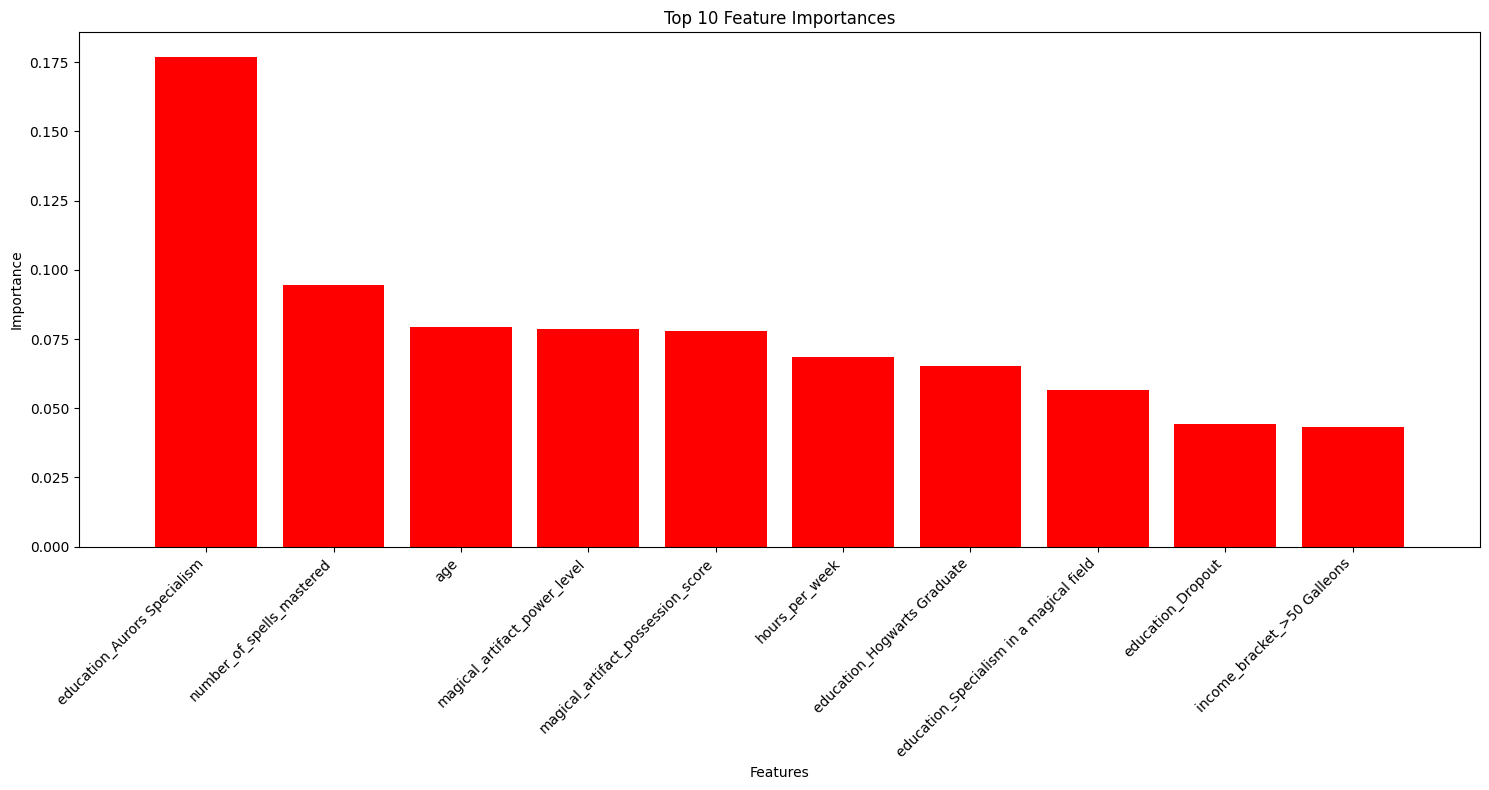

In [ ]:
importances = pipeline.named_steps['classifier'].feature_importances_

# If you used OneHotEncoder or other transformations, you need to get the feature names from the transformers
# Assuming 'preprocessor' is your ColumnTransformer and 'X_train_imputed' is a DataFrame
feature_names = X_train_imputed.columns

# Sort feature importances in descending order and select the top 10
indices = np.argsort(importances)[::-1]
top_indices = indices[:10]

# Get the top feature names and their importance
top_feature_names = feature_names[top_indices]
top_importances = importances[top_indices]


# Plot the feature importances of the forest
plt.figure(figsize=(15, 8))  # Increase figure size
plt.title("Top 10 Feature Importances")
plt.bar(range(10), top_importances, color="r", align="center")
plt.xticks(range(10), top_feature_names, rotation=45, ha='right')  # Rotate labels and align
plt.xlim([-1, 10])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

# 6. Understanding model's performance further

In [ ]:
!pip install fairlearn
from fairlearn.metrics import MetricFrame, selection_rate

Determine if the model exhibits bias by performing significantly differently across various groups. For instance, assess whether the model's performance is superior or inferior for samples where the gender is male compared to other groups.

Use the get_fairness_evaluation function to analyze the impact of this and other variables on model performance. This function uses Fairlearn to evaluate how the model fares across different classes, focusing on sensitive metrics such as accuracy, balanced accuracy, precision, and recall.

In [ ]:
def get_fairness_evaluation(X_test, y_test, y_pred, columns):
  sensitive_features_df = X_test[columns]

  def precision_wrapper(y_true, y_pred): return precision_score(y_true, y_pred, pos_label=1, zero_division=0)
  def recall_wrapper(y_true, y_pred): return recall_score(y_true, y_pred, pos_label=1, zero_division=0)

  mf = MetricFrame(metrics={
                      'accuracy': accuracy_score,
                      'balanced_accuracy': balanced_accuracy_score,
                      'precision': precision_wrapper,
                      'recall': recall_wrapper,
                      'count': lambda y_true, y_pred: y_true.shape[0]},
                  y_true=y_test,
                  y_pred=y_pred,
                  sensitive_features=sensitive_features_df)

  plot = mf.by_group.plot.bar(
    subplots=True,
    legend=True,
    figsize=[12, 8],
    title="Fairness Metrics Across Sensitive Features"
  )

  plt.tight_layout()
  plt.show()

  return mf.by_group

In [ ]:
print(X_test_imputed.columns)

Index(['age', 'hours_per_week', 'magical_artifact_possession_score',
       'magical_artifact_power_level', 'number_of_spells_mastered',
       'education_Aurors Specialism', 'education_Charms Scholar',
       'education_Dropout', 'education_Hogwarts Graduate',
       'education_Specialism in a magical field', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Never-married',
       'marital_status_Separated', 'marital_status_Widowed',
       'occupation_Auror', 'occupation_Dark Forces Defense Consultant',
       'occupation_Goblin Liaison Officer', 'occupation_Gringotts Bank',
       'occupation_Hogwarts Professor',
       'occupation_Magical Intelligence Agent', 'occupation_Magical Librarian',
       'occupation_Magical Shop Owner', 'occupation_Magical Transportation',
       'occupation_Magizoologist', 'occupation_Ministry of Magic Official',
       'occupation_Other', 'occupation_Potion Ingredients Supplier',
       'occupation_Potioneer', 'occupation_Wandl

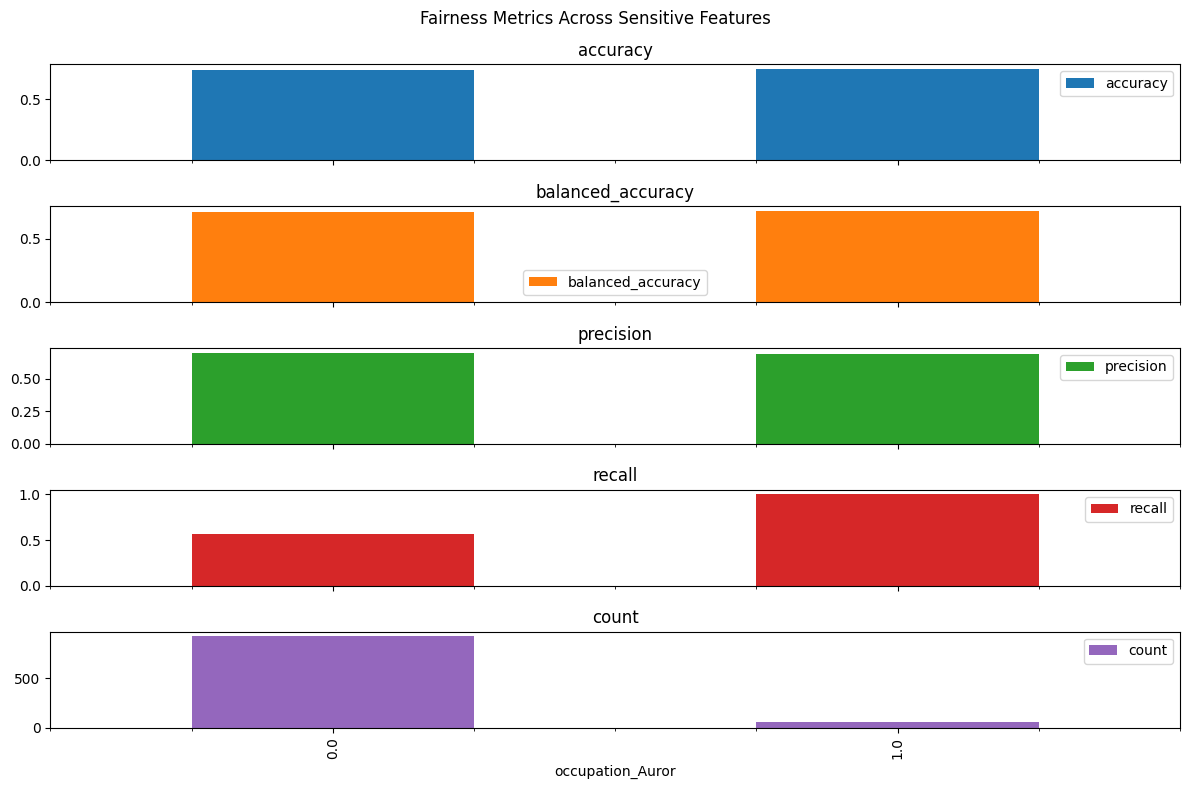

,accuracy,balanced_accuracy,precision,recall,count
occupation_Auror,,,,,
0.0,0.743287,0.709314,0.702797,0.566197,931.0
1.0,0.750000,0.720000,0.688889,1.000000,56.0


In [ ]:
get_fairness_evaluation(X_test_imputed, y_test, y_pred, ['occupation_Auror'])

Try out different combinations. For example you can pass as input to the columns feature ['bloodline', gender'].

# Sociotechnical questions

Reflection questions: As part of the assessment of this bounty you will also be graded on how you reflect on the following questions. When practicing AI Ethics, it is important to understand AI as socio-technical systems, and that although technical issues can be problematic, one need to understand the systematic and social structures giving rise to them in the first place.

- Can all problems with bias be solved technically? If not, why?
- What decision-making systems should be using algorithmic/AI approaches and which should not?
- Is it just and fair to solve problems with bias by fixing technological constraints?

### Can all problems with bias be solved technically? If not, why?

While certain aspects of bias can indeed be mitigated through technical means, it is important to recognize that not all problems with bias can be resolved purely through technological interventions. Here's why:

1. **Biases can be deeply ingrained in the data used to train AI models, often reflecting historical and societal inequalities**. For example, if a dataset used to train a hiring algorithm predominantly features successful candidates from a particular demographic group, the model may learn to favor that group, perpetuating existing biases. Technical solutions, such as data preprocessing or resampling techniques, may help reduce some biases, but they may not completely eliminate the underlying structural biases present in the data.

2. The development and deployment of AI systems involve human decision-making at various stages, from data collection and annotation to model design and evaluation. Throughout this process, **human biases can inadvertently be introduced**. For example, if the team developing an AI system lacks diversity or fails to consider multiple perspectives, their own biases may shape the system's design and performance. Technical solutions alone cannot fully address the biases stemming from human involvement in the AI development lifecycle.

3. **AI models often mirror and amplify the biases already present in society**, as they learn from data generated by humans. For example, language models trained on text data from the internet may pick up and reproduce societal biases related to gender, race, or other characteristics. While techniques like data filtering, bias detection, and debiasing methods can help alleviate some of these biases, addressing the root causes requires broader societal changes and efforts to promote equity and inclusion beyond technical interventions.
   
4. Even if an AI model itself has been technically optimized to reduce bias, the **interpretation and use of its outputs can still be subject to human biases**. For instance, if an AI system used in healthcare provides unbiased recommendations, but the healthcare professionals interpreting those recommendations hold biased views, the final decisions may still be biased. Addressing this requires ongoing training, awareness, and accountability measures beyond the technical realm

###  What decision-making systems should be using algorithmic/AI approaches and which should not?

Algorithmic/AI approaches are suitable for decision-making tasks with clear, objective criteria and reliable data. For example:

- Fraud detection systems analyze transactional data to identify suspicious patterns.
- Image classification algorithms assist radiologists in detecting abnormalities in medical images.

However, AI should be used cautiously or avoided in decisions with significant consequences for individuals, such as:

- Criminal sentencing, where AI may perpetuate biases present in the criminal justice system.
- Hiring decisions, where AI may reinforce biases related to gender, race, or other protected characteristics.

In sensitive domains like healthcare, education, and criminal justice, AI use should be carefully evaluated to prevent perpetuating biases. Thorough testing, auditing, and diverse stakeholder involvement are essential.

When AI is used in decision-making, a human-in-the-loop approach is often most effective. AI provides recommendations, while human decision-makers consider the broader context and apply ethical judgment. This collaborative approach leverages the strengths of both AI and human intelligence.

In summary, the appropriateness of AI in decision-making depends on the decision's nature, potential impact, and data reliability. AI should be used judiciously, especially in sensitive areas. A balanced approach combining AI insights with human judgment is often the most responsible way forward.

##  Is it just and fair to solve problems with bias by fixing technological constraints?

Solving bias issues in AI by only fixing technical problems is not always fair or just. Here's why:

1. Technical fixes might hide the real problems causing bias, like:
   - Social inequality
   - Historical discrimination
   - Unequal access to opportunities
   Example: An AI hiring tool might be changed to ignore race, but this doesn't fix the real issue of racial discrimination in society that led to biased hiring data.

2. Only using technical solutions could make it seem like bias is just a tech problem, not a human and societal problem too. 

3. Technical solutions often focus narrowly on specific fairness metrics, which might miss other important aspects of fairness and justice.
   Example: An AI recidivism prediction tool could be optimized for equal false positive rates across races, but this narrow technical fix ignores the broader context of racial biases in policing and the criminal justice system.

4. Marginalized communities most harmed by biased AI systems may be left out if we only rely on technical fixes. Their lived experiences and perspectives are crucial for truly fair solutions.

To solve AI bias problems fairly, we need a combination of:
- Technical solutions
- Input from affected communities and stakeholders 
- Efforts to fix underlying societal inequalities

This means involving diverse voices in AI development, being transparent, and pushing for social and policy changes to create a more just society overall. Technology can help, but it's only one part of the solution.